('Original Image Shape', (520, 696, 3))


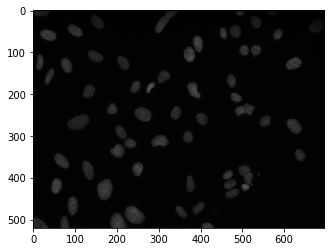

In [80]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pathlib
import cv2

training_paths = pathlib.Path('../input/stage1_train').glob('*/images/*.png')
training_sorted = sorted([x for x in training_paths])
im_path = training_sorted[45]

img_org = cv2.imread(str(im_path))
img_org_1 = cv2.imread(str(im_path))
plt.imshow(img_org)
print('Original Image Shape',img_org.shape)

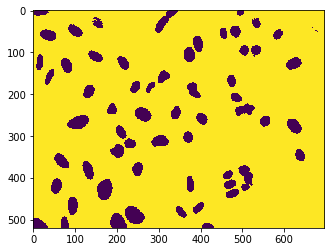

In [11]:
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.imshow(thresh)

Text(0.5,1,u'Sure Foreground')

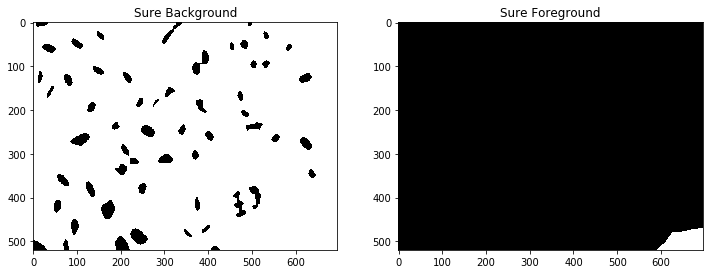

In [40]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(sure_bg,cmap='gray')
plt.title('Sure Background')
plt.subplot(1,2,2)
plt.imshow(sure_fg,cmap='gray')
plt.title('Sure Foreground')

In [44]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

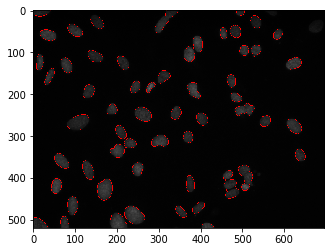

In [47]:
markers = cv2.watershed(img_org,markers)
img_org[markers == -1] = [255,0,0]

plt.imshow(img_org,cmap='gray')

In [51]:
labels, nlabels = ndimage.label(markers)
print nlabels

1


[[429 429 429 ..., 429 429 429]
 [429 429 429 ..., 429 429 429]
 [429 429 429 ..., 429 429 429]
 ..., 
 [429 429 429 ..., 429 429 429]
 [429 429 429 ..., 429 429 429]
 [429 429 429 ..., 429 429 429]]
1


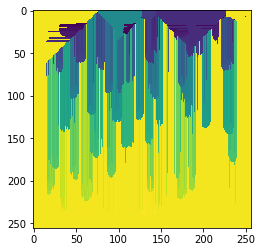

In [112]:
from skimage.feature import peak_local_max
from skimage.morphology import watershed

def gen_mask_watershed(img):
    # 1 Resizes image to desired size
    desiredShape = (256,256)
    img_1 = cv2.resize(img,desiredShape)
    
    # 2 Convert to Grayscale
    img_2 = cv2.cvtColor(img_1,cv2.COLOR_BGR2GRAY)
    
    distances = ndimage.distance_transform_edt(img_2)
    
    # Compute the local maximas, return T for peaks 
    peaks = peak_local_max(distances, indices=False, labels=img_2, min_distance=15)
    
    markers = ndimage.label(peaks,structure=np.ones((3, 3)))[0]
    labels = watershed(-distances, markers, mask=img_2)
    print labels
    
    return labels

img_res = gen_mask_watershed(img_org_1)
plt.imshow(img_res)
labels, nlabels = ndimage.label(img_res)
print nlabels